# Predictive modeling of the risk of eclampsia in pregnancy using neural network approaches

# 1. Research understanding phase

- In this study, a comprehensive analysis of the risk of eclampsia during pregnancy was provided, with data collected by age, blood pressure, heart rate, blood sugar level and body temperature. 
- Data preparation, information extraction, modeling, training and data normalization were carried out to perform data classification. 
- The dataset was correctly loaded into Hadoop, being able to use the PySparkSQL, scikit-learn and TensorFlow, using SQL and Python coding language. 
- Recurrent Neural Network and Artificial Neural Network model was applied in order to compare the best model, hyperparameters, Learning Rate Adjustment, Fine-Tuning Network Architecture, Adjusting Batch Size, and Training Neural Networks with Callbacks.
- To achieve an organized and clear understanding of the study schedule, the Cross Industry Standard Process for Data Mining (CRISP-DM) methodology was used, and the code cells were grouped according to the phases of the methodology.

## Dataset: Maternal Health Risk

### Licence of use

- That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/863/maternal+health+risk

- licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/


## About the dataset

- The Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.

###  Attributes Description:

- Age - Age in years when a woman is pregnant
- SystolicBP - Upper value of Blood Pressure in mmHg
- DiastolicBP - Lower value of Blood Pressure in mmHg
- BS - Blood glucose levels is in terms of a molar concentration, mmol/L
- BodyTemp - Body temperature in Fahrenheit
- HeartRate - Resting heart rate in beats per minute
- RiskLevel - Predicted Risk Intensity Level during pregnancy ['high risk', 'mid risk', 'low risk']

In [68]:
sc

<SparkContext master=local[*] appName=PySparkShell>



# 2. Data Understanding Phase

### Practical Big Data (PySparkSQL) - Part 1

In [69]:
# Load the libraries
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer

In [70]:
# Due the different version of python can be found and each machine or libriries 
# Avoid warnigs
import warnings
warnings.filterwarnings("ignore")

In [71]:
#Import PySparkSQL
import pyspark
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("health_data") \
    .getOrCreate()

In [72]:
# Path to dataset
csv_file = "/user1/Maternal_Health_Risk.csv"

# Read and create a temporary view
df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load(csv_file)
df.createOrReplaceTempView("rawdata")

In [73]:
# Visualise inferred schema
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)



In [74]:
# Execute an SQL query to select the first 10 rows from the temporary view
data = spark.sql("SELECT * FROM rawdata LIMIT 10")

# Directly display the query results
data.show()

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
| 23|       140|         80|7.01|    98.0|       70|high risk|
| 23|       130|         70|7.01|    98.0|       78| mid risk|
| 35|        85|         60|11.0|   102.0|       86|high risk|
| 32|       120|         90| 6.9|    98.0|       70| mid risk|
| 42|       130|         80|18.0|    98.0|       70|high risk|
+---+----------+-----------+----+--------+---------+---------+



In [75]:
# Count rows
num_rows = spark.sql("SELECT COUNT(*) as TotalRows FROM rawdata").show()

# Count columns using the PySpark DataFrame (not directly SQL)
num_columns = len(df.columns)
print(f"Number of Columns: {num_columns}")

+---------+
|TotalRows|
+---------+
|     1014|
+---------+

Number of Columns: 7


# 3. EDA and Visualization

### Missing values

In [76]:
from pyspark.sql.functions import col, sum as _sum, when

# Listing the number of missing values per column
df.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

+---+----------+-----------+---+--------+---------+---------+
|Age|SystolicBP|DiastolicBP| BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+---+--------+---------+---------+
|  0|         0|          0|  0|       0|        0|        0|
+---+----------+-----------+---+--------+---------+---------+



In [77]:
# Collecting data for visualization
risk_level_distribution = spark.sql("SELECT RiskLevel, COUNT(*) as Count FROM rawdata GROUP BY RiskLevel").toPandas()

# Check the collected data
print(risk_level_distribution)

   RiskLevel  Count
0   low risk    406
1   mid risk    336
2  high risk    272


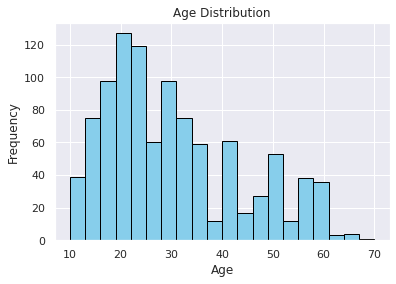

In [78]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("health_data")

# Extract age data using Spark SQL
age_data = spark.sql("SELECT Age FROM health_data").rdd.flatMap(lambda x: x).collect()

# Plot age distribution
plt.hist(age_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [79]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("health_data")

# Age Distribution Analysis
age_distribution_query = """
    SELECT Age, COUNT(*) AS Frequency
    FROM health_data
    GROUP BY Age
    ORDER BY Age
"""

age_distribution = spark.sql(age_distribution_query)

# Display age distribution
age_distribution.show()

+---+---------+
|Age|Frequency|
+---+---------+
| 10|        4|
| 12|       35|
| 13|       12|
| 14|        3|
| 15|       60|
| 16|       16|
| 17|       63|
| 18|       19|
| 19|       67|
| 20|       22|
| 21|       38|
| 22|       45|
| 23|       71|
| 24|        3|
| 25|       48|
| 26|        3|
| 27|        9|
| 28|       28|
| 29|       40|
| 30|       30|
+---+---------+
only showing top 20 rows



In [80]:
# Age-Risk Relationship Analysis
age_risk_query = """
    SELECT
        CASE WHEN Age <= 20 THEN '0-20'
             WHEN Age BETWEEN 21 AND 30 THEN '21-30'
             WHEN Age BETWEEN 31 AND 40 THEN '31-40'
             WHEN Age BETWEEN 41 AND 50 THEN '41-50'
             ELSE 'Above 50' END AS Age_Group,
        AVG(CASE WHEN RiskLevel = 'low risk' THEN 1 ELSE 0 END) AS Low_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'mid risk' THEN 1 ELSE 0 END) AS Mid_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'high risk' THEN 1 ELSE 0 END) AS High_Risk_Avg
    FROM health_data
    GROUP BY Age_Group
    ORDER BY Age_Group
"""

age_risk_relationship = spark.sql(age_risk_query)

# Display Age-Risk Relationship
age_risk_relationship.show()

+---------+-------------------+-------------------+-------------------+
|Age_Group|       Low_Risk_Avg|       Mid_Risk_Avg|      High_Risk_Avg|
+---------+-------------------+-------------------+-------------------+
|     0-20| 0.4983388704318937|0.37209302325581395|0.12956810631229235|
|    21-30|0.43174603174603177| 0.3904761904761905|0.17777777777777778|
|    31-40| 0.2677595628415301|0.23497267759562843| 0.4972677595628415|
|    41-50|0.31666666666666665|              0.275| 0.4083333333333333|
| Above 50| 0.3473684210526316| 0.2631578947368421| 0.3894736842105263|
+---------+-------------------+-------------------+-------------------+



In [81]:
# Blood Pressure-Risk Relationship Analysis
bp_risk_query = """
    SELECT 
        CASE
            WHEN SystolicBP <= 120 AND DiastolicBP <= 80 THEN 'Normal'
            WHEN SystolicBP > 120 AND SystolicBP <= 129 AND DiastolicBP <= 80 THEN 'Elevated'
            WHEN SystolicBP >= 130 AND SystolicBP <= 139 OR DiastolicBP >= 80 AND DiastolicBP <= 89 THEN 'Stage 1 High'
            WHEN SystolicBP >= 140 OR DiastolicBP >= 90 THEN 'Stage 2 High'
            ELSE 'Other' 
        END AS BP_Category,
        AVG(CASE WHEN RiskLevel = 'low risk' THEN 1 ELSE 0 END) AS Low_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'mid risk' THEN 1 ELSE 0 END) AS Mid_Risk_Avg,
        AVG(CASE WHEN RiskLevel = 'high risk' THEN 1 ELSE 0 END) AS High_Risk_Avg
    FROM health_data
    GROUP BY BP_Category
"""

bp_risk_relationship = spark.sql(bp_risk_query)

# Display Blood Pressure-Risk Relationship
bp_risk_relationship.show()

+------------+-------------------+------------------+------------------+
| BP_Category|       Low_Risk_Avg|      Mid_Risk_Avg|     High_Risk_Avg|
+------------+-------------------+------------------+------------------+
|Stage 2 High|0.25660377358490566|               0.2|0.5433962264150943|
|Stage 1 High|0.20161290322580644|0.5483870967741935|              0.25|
|      Normal|             0.5008|             0.344|            0.1552|
+------------+-------------------+------------------+------------------+



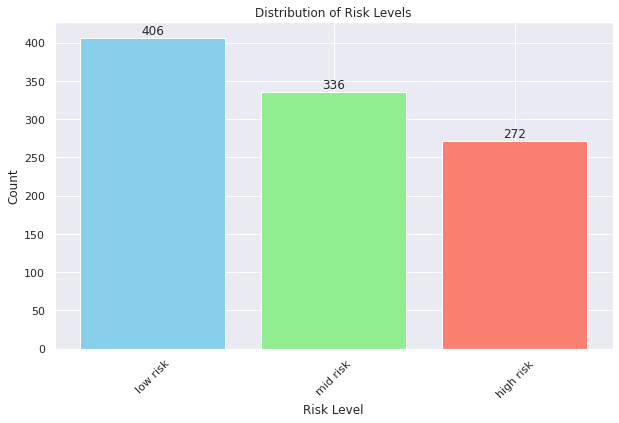

In [82]:
import matplotlib.pyplot as plt

# Plotting the distribution of Risk Levels with counts above bars
plt.figure(figsize=(10, 6))
bars = plt.bar(risk_level_distribution['RiskLevel'], risk_level_distribution['Count'], color=['skyblue', 'lightgreen', 'salmon'])

# Adding counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Comparative bar chart for average Systolic and Diastolic blood pressure, by Risk Level level.

In [83]:
# Determining the associations between the average systolic and diastolic blood pressures (SystolicBP and DiastolicBP, respectively) and the RiskLevel.
pressure_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(SystolicBP) AS AvgSystolicBP, 
    AVG(DiastolicBP) AS AvgDiastolicBP 
FROM rawdata 
GROUP BY RiskLevel
""").toPandas()

- The purpose of the query is to evaluate the data with an emphasis on determining the associations between the average systolic and diastolic blood pressures SystolicBP and DiastolicBP, respectively and the RiskLevel.

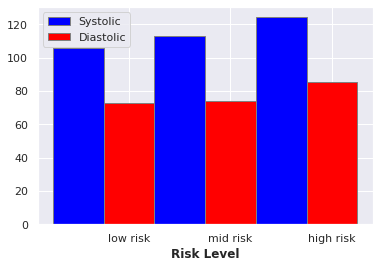

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Bar width
barWidth = 0.50

# Setting the position of the bars
r1 = np.arange(len(pressure_risk['RiskLevel']))
r2 = [x + barWidth for x in r1]

# Creating the bars
plt.bar(r1, pressure_risk['AvgSystolicBP'], color='blue', width=barWidth, edgecolor='grey', label='Systolic')
plt.bar(r2, pressure_risk['AvgDiastolicBP'], color='red', width=barWidth, edgecolor='grey', label='Diastolic')

# Adding labels to the bars
plt.xlabel('Risk Level', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(pressure_risk['RiskLevel']))], pressure_risk['RiskLevel'])

# Creating the legend and showing the plot
plt.legend()
plt.show()

### Average Age by Risk Level chart

In [85]:
age_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(Age) AS AvgAge 
FROM rawdata 
GROUP BY RiskLevel
ORDER BY CASE 
    WHEN RiskLevel = 'low risk' THEN 1
    WHEN RiskLevel = 'mid risk' THEN 2
    WHEN RiskLevel = 'high risk' THEN 3
    ELSE 4
END
""").toPandas()

- By analyzing how the average age varies between different risk levels, through this analysis it is possible to identify age-related patterns or trends that may be relevant to understanding risk.

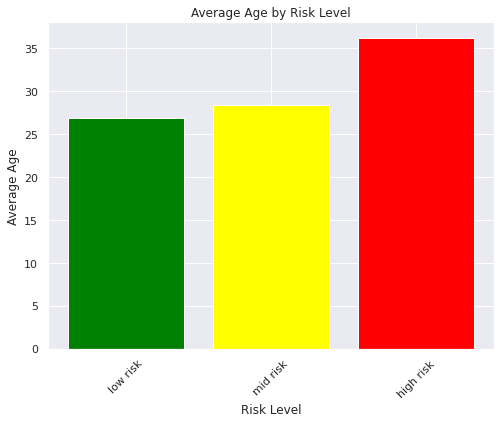

In [86]:
import matplotlib.pyplot as plt

# Adjusting color_mapping to match the exact strings from the SQL query
color_mapping = {
    'high risk': 'red',    # Matching 'high risk' to red
    'mid risk': 'yellow',  # Matching 'mid risk' to yellow
    'low risk': 'green'    # Matching 'low risk' to green
}

# Applying the color mapping to generate a list of colors for each bar
# This assumes age_risk['RiskLevel'] contains 'low risk', 'mid risk', 'high risk'
bar_colors = [color_mapping[risk_level] for risk_level in age_risk['RiskLevel']]

plt.figure(figsize=(8, 6))
plt.bar(age_risk['RiskLevel'], age_risk['AvgAge'], color=bar_colors)

# Adding titles and labels
plt.title('Average Age by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Average Age')
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability

# Displaying the chart
plt.show()

- This chart provides a clear visualization of how the average age varies between different risk levels. This can help identify whether there is an age trend associated with risk level.

# 4. Modeling Phase for Neural Network (RNN AND ANN)

##  RNN Neural Network 

In [87]:
from pyspark.sql import SparkSession

# Initializing Spark session
spark = SparkSession.builder \
    .appName("Maternal Health Risk Analysis") \
    .getOrCreate()

# Loading data from the corrected CSV file
csv_file_path = "/user1/Maternal_Health_Risk.csv"
data = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Displaying the first few rows and the structure of the data
data.show(5)
data.printSchema()

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
+---+----------+-----------+----+--------+---------+---------+
only showing top 5 rows

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)



In [88]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer
from pyspark.ml import Pipeline

# Encoding the 'RiskLevel' label into a numerical representation
indexer = StringIndexer(inputCol="RiskLevel", outputCol="label")

# Assembling all the features into a single vector column
assembler = VectorAssembler(inputCols=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"], outputCol="features")

# Normalizing the features
normalizer = Normalizer(inputCol="features", outputCol="features_norm")

# Building the pipeline
pipeline = Pipeline(stages=[indexer, assembler, normalizer])

# Applying the pipeline to the data
data_transformed = pipeline.fit(data).transform(data)

# Now the data is ready to be used with an RNN model.
data_transformed.show(5)

+---+----------+-----------+----+--------+---------+---------+-----+--------------------+--------------------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|label|            features|       features_norm|
+---+----------+-----------+----+--------+---------+---------+-----+--------------------+--------------------+
| 25|       130|         80|15.0|    98.0|       86|high risk|  2.0|[25.0,130.0,80.0,...|[0.12324096461179...|
| 35|       140|         90|13.0|    98.0|       70|high risk|  2.0|[35.0,140.0,90.0,...|[0.16762344453220...|
| 29|        90|         70| 8.0|   100.0|       80|high risk|  2.0|[29.0,90.0,70.0,8...|[0.16658690276323...|
| 30|       140|         85| 7.0|    98.0|       70|high risk|  2.0|[30.0,140.0,85.0,...|[0.14590293809487...|
| 35|       120|         60| 6.1|    98.0|       76| low risk|  0.0|[35.0,120.0,60.0,...|[0.18804649773233...|
+---+----------+-----------+----+--------+---------+---------+-----+--------------------+--------------------+
o

## Defining the architecture to RNN

In [89]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# The input layer has the size of the normalized features column,
# Two hidden layers with 5 and 4 neurons, respectively,
# And an output layer with 3 neurons (assuming there are 3 risk classes).
layers = [6, 5, 4, 3]  # Modify as needed

# Creating the classifier
mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, maxIter=100, featuresCol="features_norm", labelCol="label")

# Training the model
model = mlp.fit(data_transformed)

# Making predictions
predictions = model.transform(data_transformed)

# Evaluating the model
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5927021696252466


## Hyperparameter Tuning

In [90]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define a list of architectures to test
# Each element of the list is a layer configuration for the model
# Example: [4, 5, 4, 3] -> input layer with 4 neurons, two hidden layers with 5 and 4 neurons, and output layer with 3 neurons
layer_configs = [
    [6, 5, 4, 3],
    [6, 10, 5, 3],
    [6, 20, 10, 5, 3]
]

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

best_model = None
best_accuracy = 0
best_layers = None

for layers in layer_configs:
    mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, maxIter=100, featuresCol="features_norm", labelCol="label")
    model = mlp.fit(data_transformed)
    predictions = model.transform(data_transformed)
    accuracy = evaluator.evaluate(predictions)
    print(f"Layers: {layers} -> Accuracy: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_layers = layers

print(f"Best Model Layers: {best_layers} with Accuracy: {best_accuracy}")

Layers: [6, 5, 4, 3] -> Accuracy: 0.5927021696252466
Layers: [6, 10, 5, 3] -> Accuracy: 0.6045364891518737
Layers: [6, 20, 10, 5, 3] -> Accuracy: 0.5857988165680473
Best Model Layers: [6, 10, 5, 3] with Accuracy: 0.6045364891518737


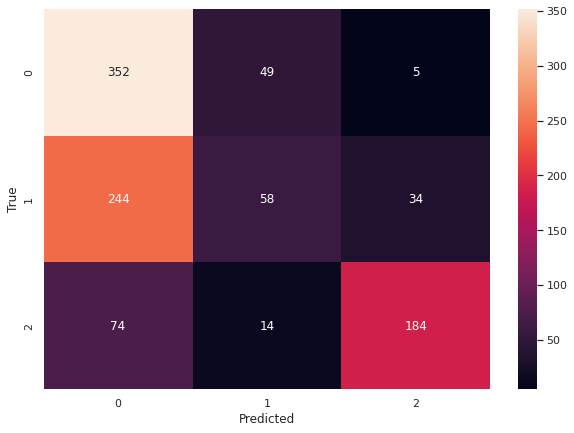

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # For better visualization of the confusion matrix

# Assuming 'predictions' is your Spark DataFrame with the model predictions
# and that this DataFrame has a 'prediction' column with the predictions and 'label' with the true labels.
y_true = predictions.select("label").collect()
y_pred = predictions.select("prediction").collect()

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [92]:
from sklearn.metrics import classification_report

# Calculating precision, recall, and F1-score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.87      0.65       406
         1.0       0.48      0.17      0.25       336
         2.0       0.83      0.68      0.74       272

    accuracy                           0.59      1014
   macro avg       0.61      0.57      0.55      1014
weighted avg       0.59      0.59      0.55      1014



- The model performs best in classifying class 2.0 but struggles particularly with class 1.0, especially in terms of recall. The overall accuracy of 59% and the disparities in performance across classes suggest there may be room for improvement, possibly through techniques such as rebalancing the dataset

# ANN Model

In [93]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Preparing the data
# Let's convert Spark DataFrame to pandas DataFrame for this example.
# Note that this may not be efficient for large datasets.
pandas_df = data_transformed.toPandas()

# Separating features and labels
X = pandas_df[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]  # Adjust according to your features
y = pandas_df['label']  # Adjust according to your label column

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converting labels to categorical representation
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Building the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(5, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
epochs = 50  # Setting the number of epochs
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

# Evaluating the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3197 - loss: 1.1462 - val_accuracy: 0.3006 - val_loss: 1.1379
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3439 - loss: 1.1048 - val_accuracy: 0.2883 - val_loss: 1.1141
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3977 - loss: 1.0865 - val_accuracy: 0.3497 - val_loss: 1.0967
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4530 - loss: 1.0722 - val_accuracy: 0.3926 - val_loss: 1.0788
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4781 - loss: 1.0555 - val_accuracy: 0.3988 - val_loss: 1.0647
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4983 - loss: 1.0380 - val_accuracy: 0.3988 - val_loss: 1.0503
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5427 - loss: 0.9855 - val_accuracy: 0.4356 - val_loss: 1.0359
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5943 - loss: 0.9760 - val_accuracy: 0.4479 - va

## Prediction Model working with Scikit-learn 

In [96]:
import numpy as np
import pandas as pd
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf

# Uing the model described to make predictions:

# Making predictions
yhat_probs = model.predict(X_test)

# Converting probabilities to class labels
yhat_classes = np.argmax(yhat_probs, axis=1)

# Converting y_test from one-hot encoding to class labels if necessary
y_test_classes = np.argmax(y_test, axis=1)

# Generating the classification report
report = metrics.classification_report(y_test_classes, yhat_classes, output_dict=True)

# Converting the report to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()

print(report_df)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score     support
0              0.605042  0.900000  0.723618   80.000000
1              0.656250  0.276316  0.388889   76.000000
2              0.750000  0.829787  0.787879   47.000000
accuracy       0.650246  0.650246  0.650246    0.650246
macro avg      0.670431  0.668701  0.633462  203.000000
weighted avg   0.657775  0.650246  0.613179  203.000000


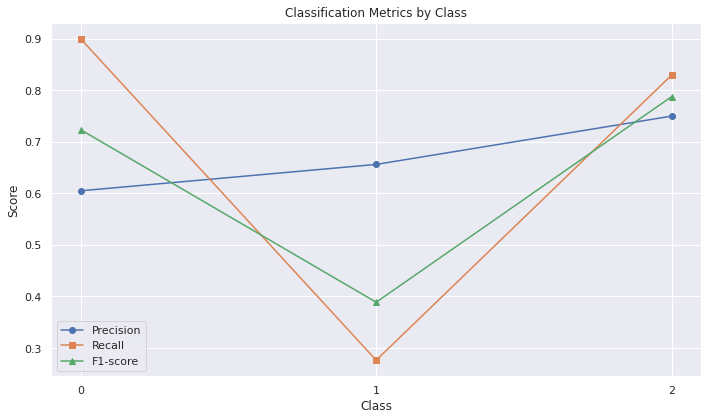

In [97]:
import matplotlib.pyplot as plt

# Extracting precision, recall, and F1-score from the classification report
precision = report_df['precision'][:-3]
recall = report_df['recall'][:-3]
f1_score = report_df['f1-score'][:-3]
classes = precision.index.tolist()

# Plotting precision, recall, and F1-score for each class
plt.figure(figsize=(10, 6))
plt.plot(classes, precision, marker='o', label='Precision')
plt.plot(classes, recall, marker='s', label='Recall')
plt.plot(classes, f1_score, marker='^', label='F1-score')
plt.title('Classification Metrics by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(classes)
plt.tight_layout()
plt.show()

## Learning Rate Adjustment

In [98]:
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
      tf.keras.layers.Dense(5, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f'Training model with learning rate: {lr}')
    history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    print(f'Validation Accuracy: {val_acc}')

Training model with learning rate: 0.001
Validation Accuracy: 0.558282196521759
Training model with learning rate: 0.01
Validation Accuracy: 0.6564416885375977
Training model with learning rate: 0.1
Validation Accuracy: 0.6687116622924805


## Exploring Optimizers

In [99]:
optimizers = ['adam', 'sgd', 'rmsprop']

for opt_name in optimizers:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
      tf.keras.layers.Dense(5, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.get(opt_name)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f'Training model with optimizer: {opt_name}')
    history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    print(f'Validation Accuracy: {val_acc}')

Training model with optimizer: adam
Validation Accuracy: 0.3987730145454407
Training model with optimizer: sgd
Validation Accuracy: 0.4969325065612793
Training model with optimizer: rmsprop
Validation Accuracy: 0.47852760553359985


## Adjusting Batch Size

In [100]:
batch_sizes = [16, 32, 64]

for batch_size in batch_sizes:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
      tf.keras.layers.Dense(5, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f'Training model with batch size: {batch_size}')
    history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=batch_size, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    print(f'Validation Accuracy: {val_acc}')

Training model with batch size: 16
Validation Accuracy: 0.5398772954940796
Training model with batch size: 32
Validation Accuracy: 0.558282196521759
Training model with batch size: 64
Validation Accuracy: 0.4907975494861603


## Fine-Tuning the Network Architecture
Now with a better understanding of the hyperparameters, adjusting these aspects in practice using TensorFlow Keras

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Defining the network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

# Compiling the model with the RMSprop optimizer (with the correct parameter)
model.compile(optimizer=RMSprop(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4151 - loss: 3.2577 - val_accuracy: 0.4233 - val_loss: 1.0136
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5247 - loss: 1.0212 - val_accuracy: 0.5399 - val_loss: 1.0553
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5627 - loss: 0.9973 - val_accuracy: 0.5890 - val_loss: 0.8108
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5368 - loss: 1.0883 - val_accuracy: 0.3497 - val_loss: 1.0520
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4445 - loss: 0.9814 - val_accuracy: 0.5644 - val_loss: 0.8690
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6171 - loss: 0.8177 - val_accuracy: 0.5276 - val_loss: 0.9672
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5754 - loss: 0.8539 - val_accuracy: 0.4908 - val_loss: 0.9062
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5485 - loss: 0.9298 - val_accuracy: 0.5521 - val_

- Comments
Variation in Accuracy and Loss: There is considerable variation in accuracy and loss in both the training and validation sets across epochs. This could indicate that the model is learning, but it could also be suffering from volatility during training.
Initial Improvement Followed by Stagnation: The model shows signs of initial improvement in terms of accuracy and loss, which is a good sign. However, there seem to be moments of stagnation or even regression in terms of performance.
Overfitting: There is evidence of overfitting, given that in some epochs the validation loss increases while the training loss continues to decrease. This suggests that the model may be overfitting the training data.

## Training Neural Networks with Callbacks

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

# Defining the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

callbacks_list = [early_stopping, model_checkpoint]

# Building the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

# Compiling the model with the RMSprop optimizer
model.compile(optimizer=RMSprop(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model with the callbacks
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=callbacks_list,
                    verbose=1)


Epoch 1/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3793 - loss: 2.4766
Epoch 1: val_loss improved from inf to 1.30879, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3812 - loss: 2.4156 - val_accuracy: 0.4663 - val_loss: 1.3088
Epoch 2/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5510 - loss: 0.9800
Epoch 2: val_loss improved from 1.30879 to 0.89589, saving model to best_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5391 - loss: 0.9926 - val_accuracy: 0.5092 - val_loss: 0.8959
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5073 - loss: 1.0575
Epoch 3: val_loss did not improve from 0.89589
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5065 - loss: 1.0580 - val_accuracy: 0.5276 - val_loss: 1.1041
Epoch 4/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4933 - loss: 1.1120
Epoch 4: val_loss did not improve from 0.89589
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.49

Epoch 26/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6279 - loss: 0.8217
Epoch 26: val_loss did not improve from 0.74693
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6279 - loss: 0.8226 - val_accuracy: 0.5092 - val_loss: 0.9913
Epoch 27/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5695 - loss: 0.9526
Epoch 27: val_loss did not improve from 0.74693
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5742 - loss: 0.9389 - val_accuracy: 0.5521 - val_loss: 0.7972
Epoch 28/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6379 - loss: 0.7870
Epoch 28: val_loss did not improve from 0.74693
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6356 - loss: 0.7906 - val_accuracy: 0.5828 - val_loss: 0.7910
Epoch 29/50
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6089 - loss: 0.8660
Epoch 29: val_loss did not improve from 0.74693
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6090 - loss: 0.8671 - val_accuracy: 0.6258 - val_loss: 0.7819
Epoch

In [56]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.keras')

# Evaluate the loaded model on the test or validation set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5331 - loss: 0.9753  
Test loss: 0.9553058743476868, Test accuracy: 0.5320196747779846


### Accuracy and Loss Plot

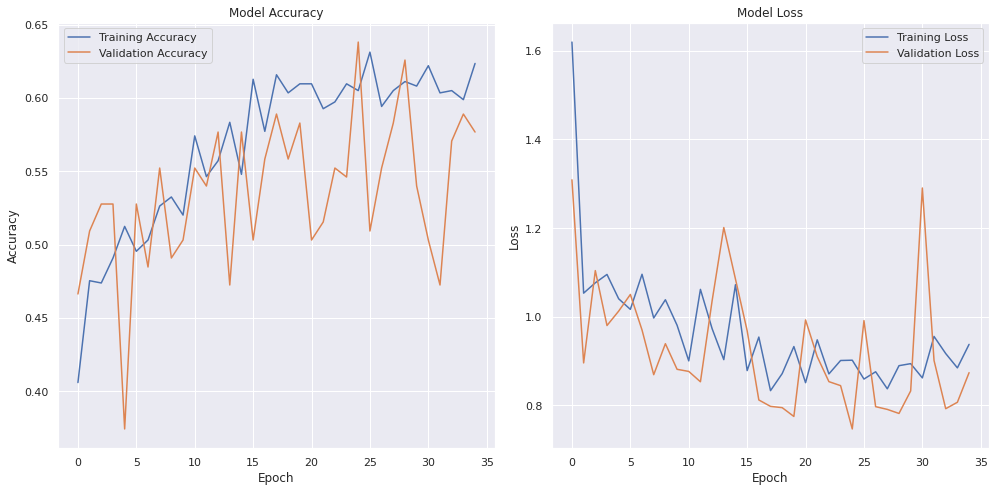

In [103]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion on RNN and ANN Model
- Observing the accuracy results of the models, the RNN model presented 0.592, and after using hyperparameters the accuracy was 0.604. So that for ANN the accuracy obtained was 0.657 and After careful evaluation with hyperparameter adjustment, learning rate adjustment, network architecture fine-tuning, batch size adjustment and neural network training with callbacks the accuracy result was 0.532. It can be concluded that the first ANN model offers the best balance between accuracy and simplicity, so it makes sense to consider this.